In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 6 are of type VARIABLE
 - 1 are of type NOTICE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [4]:
data_bz = data["b2dz"]  
data_bx = data["b2dx"]  
data_by = data["b2dy"]  

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 41.6

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [5]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [6]:
data2d = Field2dData(nresol_x, nresol_y, nresol_z, nf_max, pixelsize_x_Mm, pixelsize_y_Mm, pixelsize_z_Mm, x_arr, y_arr, z_arr, data_bz)

In [7]:
alpha = 0.01

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm 
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.3041729734388671


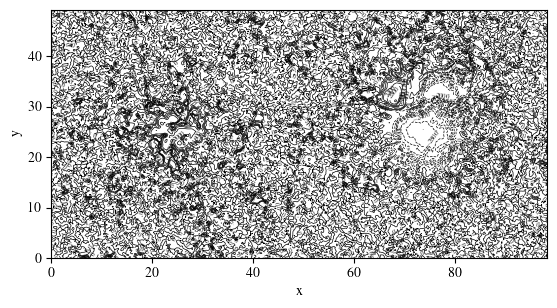

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    18,
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax_Mm/xmax_Mm)
ax.clabel(CS, fontsize=5, inline=True)
plt.show()

In [9]:
data3dmhs2 = calculate_magfield(data2d, 0.3, 1.0, 0.01, z0, deltaz)

path2saveMHS2 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS2"
data3dmhs2.save(path2saveMHS2)

In [ ]:
data3dmhs1 = calculate_magfield(data2d, 0.15, 1.0, 0.01, z0, deltaz)

path2saveMHS1 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS1"
data3dmhs1.save(path2saveMHS1)

In [ ]:
data3dpot = calculate_magfield(data2d, 0.0, 1.0, 0.0, z0, deltaz)

path2savepot = "/Users/lilli/Desktop/mflex/ISSIRMHD/Potential"
data3dpot.save(path2savepot)

In [ ]:
data3dlff = calculate_magfield(data2d, 0.0, 1.0 , 0.01, z0, deltaz)

path2saveLFF = "/Users/lilli/Desktop/mflex/ISSIRMHD/LFF"
data3dlff.save(path2saveLFF)